# Spatial data
Based off: https://geographicdata.science/book/notebooks/10_clustering_and_regionalization.html


In [1]:
from esda.moran import Moran
from libpysal.weights import Queen, KNN
import seaborn
import pandas
import geopandas
import numpy
import matplotlib.pyplot as plt
import os

C:\Users\erics\AppData\Roaming\Python\Python39\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\erics\AppData\Roaming\Python\Python39\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


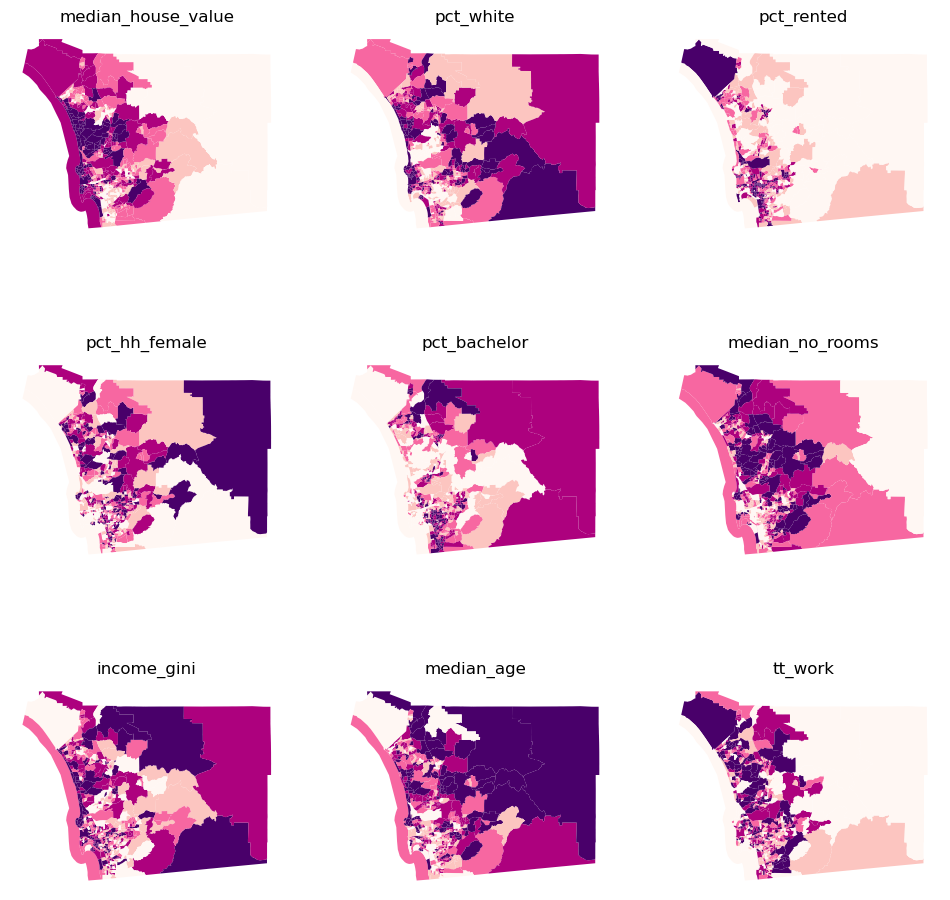

In [2]:
# Read file

db = geopandas.read_file(os.getcwd()+"/sandiego_tracts.gpkg")
cluster_variables = [
    "median_house_value",  # Median house value
    "pct_white",  # % tract population that is white
    "pct_rented",  # % households that are rented
    "pct_hh_female",  # % female-led households
    "pct_bachelor",  # % tract population with a Bachelors degree
    "median_no_rooms",  # Median n. of rooms in the tract's households
    "income_gini",  # Gini index measuring tract wealth inequality
    "median_age",  # Median age of tract population
    "tt_work",  # Travel time to work
]
f, axs = plt.subplots(nrows=3, ncols=3, figsize=(12, 12))
# Make the axes accessible with single indexing
axs = axs.flatten()
# Start a loop over all the variables of interest
for i, col in enumerate(cluster_variables):
    # select the axis where the map will go
    ax = axs[i]
    # Plot the map
    db.plot(
        column=col,
        ax=ax,
        scheme="Quantiles",
        linewidth=0,
        cmap="RdPu",
    )
    # Remove axis clutter
    ax.set_axis_off()
    # Set the axis title to the name of variable being plotted
    ax.set_title(col)
# Display the figure
plt.show()

In [3]:
w = Queen.from_dataframe(db)
# Set seed for reproducibility
numpy.random.seed(123456)
# Calculate Moran's I for each variable
mi_results = [
    Moran(db[variable], w) for variable in cluster_variables
]
# Structure results as a list of tuples
mi_results = [
    (variable, res.I, res.p_sim)
    for variable, res in zip(cluster_variables, mi_results)
]
# Display on table
table = pandas.DataFrame(
    mi_results, columns=["Variable", "Moran's I", "P-value"]
).set_index("Variable")
table

C:\Users\erics\AppData\Local\Temp\ipykernel_4812\27899226.py:1: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(db)


,Moran's I,P-value
Variable,,
median_house_value,0.646618,0.001
pct_white,0.602079,0.001
pct_rented,0.451372,0.001
pct_hh_female,0.282239,0.001
pct_bachelor,0.433082,0.001
median_no_rooms,0.538996,0.001
income_gini,0.295064,0.001
median_age,0.381440,0.001
tt_work,0.102748,0.001


In [4]:
db[["income_gini", "median_house_value"]].head()

,income_gini,median_house_value
0,0.5355,732900.000000
1,0.4265,473800.000000
2,0.4985,930600.000000
3,0.4003,478500.000000
4,0.3196,515570.896382


In [5]:
from sklearn import metrics
metrics.pairwise_distances(
    db[["income_gini", "median_house_value"]].head()
).round(4)

array([[     0.    , 259100.    , 197700.    , 254400.    , 217329.1036],
       [259100.    ,      0.    , 456800.    ,   4700.    ,  41770.8964],
       [197700.    , 456800.    ,      0.    , 452100.    , 415029.1036],
       [254400.    ,   4700.    , 452100.    ,      0.    ,  37070.8964],
       [217329.1036,  41770.8964, 415029.1036,  37070.8964,      0.    ]])

In [6]:
from sklearn.preprocessing import robust_scale
db_scaled = robust_scale(db[cluster_variables])

## K-Means

In [7]:
# Initialize KMeans instance
from sklearn.cluster import KMeans
# Initialize KMeans instance
kmeans = KMeans(n_clusters=5)
# Set the seed for reproducibility
numpy.random.seed(1234)
# Run K-Means algorithm
k5cls = kmeans.fit(db_scaled)

C:\Users\erics\AppData\Roaming\Python\Python39\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\erics\AppData\Roaming\Python\Python39\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


In [8]:
# Print first five labels
k5cls.labels_[:5]

array([2, 1, 3, 1, 4])

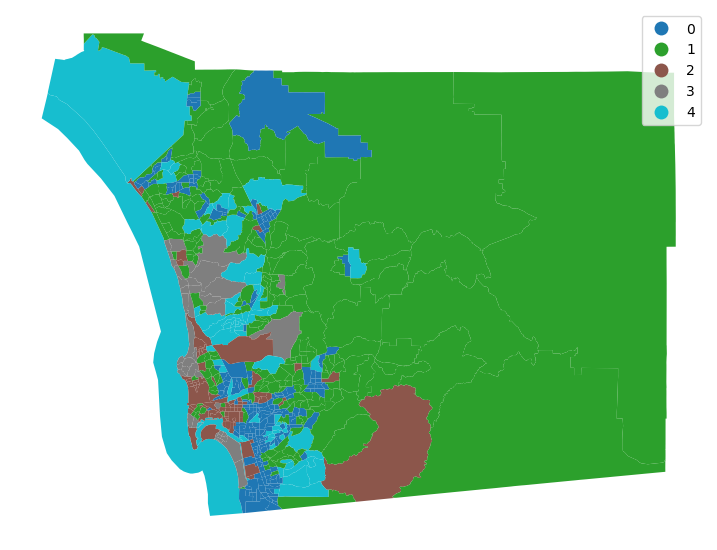

In [9]:
# Assign labels into a column
db["k5cls"] = k5cls.labels_
# Set up figure and ax
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot unique values choropleth including
# a legend and with no boundary lines
db.plot(
    column="k5cls", categorical=True, legend=True, linewidth=0, ax=ax
)
# Remove axis
ax.set_axis_off()
# Display the map
plt.show()

# Hierarchical Clustering

In [10]:
from sklearn.cluster import AgglomerativeClustering
# Set seed for reproducibility
numpy.random.seed(0)
# Initialize the algorithm
model = AgglomerativeClustering(linkage="ward", n_clusters=5)
# Run clustering
model.fit(db_scaled)
# Assign labels to main data table
db["ward5"] = model.labels_
ward5sizes = db.groupby("ward5").size()
ward5sizes

ward5
0    198
1     10
2     48
3    287
4     85
dtype: int64

In [11]:
ward5means = db.groupby("ward5")[cluster_variables].mean()
ward5means.T.round(3)

ward5,0,1,2,3,4
median_house_value,365932.350,625607.090,1202087.604,503608.711,503905.198
pct_white,0.589,0.598,0.871,0.770,0.766
pct_rented,0.573,0.360,0.285,0.287,0.657
pct_hh_female,0.105,0.098,0.107,0.112,0.076
pct_bachelor,0.023,0.006,0.002,0.009,0.006
median_no_rooms,4.566,5.860,6.010,5.738,3.904
income_gini,0.405,0.394,0.480,0.394,0.442
median_age,31.955,34.250,45.196,40.695,33.540
tt_work,2181.970,9260.400,1766.354,2268.718,2402.671


In [12]:
# Index db on cluster ID
tidy_db = db.set_index("ward5")
# Keep only variables used for clustering
tidy_db = tidy_db[cluster_variables]
# Stack column names into a column, obtaining
# a "long" version of the dataset
tidy_db = tidy_db.stack()
# Take indices into proper columns
tidy_db = tidy_db.reset_index()
# Rename column names
tidy_db = tidy_db.rename(
    columns={"level_1": "Attribute", 0: "Values"}
)
# Check out result
tidy_db.head()

,ward5,Attribute,Values
0,4,median_house_value,732900.000000
1,4,pct_white,0.916988
2,4,pct_rented,0.373913
3,4,pct_hh_female,0.052896
4,4,pct_bachelor,0.000000


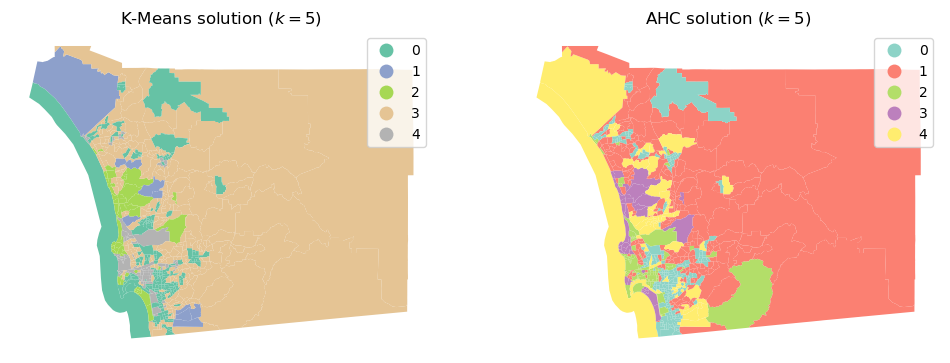

In [15]:
db["ward5"] = model.labels_
# Set up figure and ax
f, axs = plt.subplots(1, 2, figsize=(12, 6))

### K-Means ###
ax = axs[0]
# Plot unique values choropleth including
# a legend and with no boundary lines
db.plot(
    column="ward5",
    categorical=True,
    cmap="Set2",
    legend=True,
    linewidth=0,
    ax=ax,
)
# Remove axis
ax.set_axis_off()
# Add title
ax.set_title("K-Means solution ($k=5$)")

### AHC ###
ax = axs[1]
# Plot unique values choropleth including
# a legend and with no boundary lines
db.plot(
    column="k5cls",
    categorical=True,
    cmap="Set3",
    legend=True,
    linewidth=0,
    ax=ax,
)
# Remove axis
ax.set_axis_off()
# Add title
ax.set_title("AHC solution ($k=5$)")

# Display the map
plt.show()

# Regionalization: spatially constrained hierarchical clustering

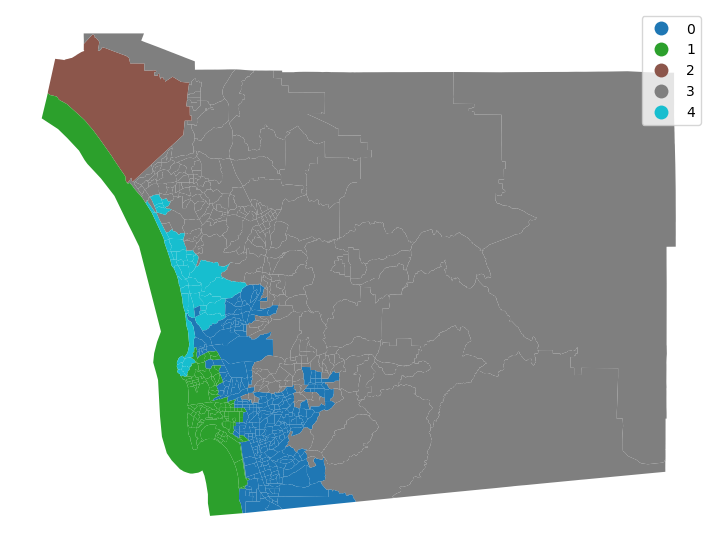

In [16]:
# Set the seed for reproducibility
numpy.random.seed(123456)
# Specify cluster model with spatial constraint
model = AgglomerativeClustering(
    linkage="ward", connectivity=w.sparse, n_clusters=5
)
# Fit algorithm to the data
model.fit(db_scaled)
db["ward5wq"] = model.labels_
# Set up figure and ax
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot unique values choropleth including a legend and with no boundary lines
db.plot(
    column="ward5wq",
    categorical=True,
    legend=True,
    linewidth=0,
    ax=ax,
)
# Remove axis
ax.set_axis_off()
# Display the map
plt.show()

Using KNN for spatial constraint


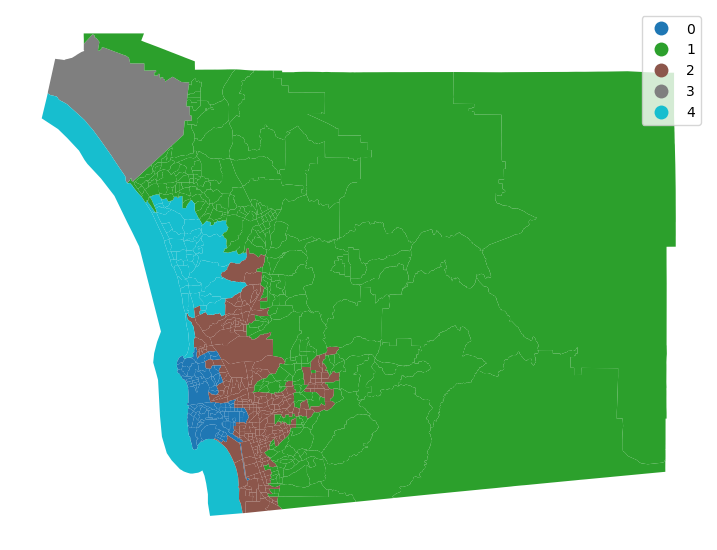

In [17]:
w = KNN.from_dataframe(db, k=4)
# Set the seed for reproducibility
numpy.random.seed(123456)
# Specify cluster model with spatial constraint
model = AgglomerativeClustering(
    linkage="ward", connectivity=w.sparse, n_clusters=5
)
# Fit algorithm to the data
model.fit(db_scaled)
db["ward5wknn"] = model.labels_
# Setup figure and ax
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot unique values choropleth
# including a legend and with no boundary lines
db.plot(
    column="ward5wknn",
    categorical=True,
    legend=True,
    linewidth=0,
    ax=ax,
)
# Remove axis
ax.set_axis_off()
# Display the map
plt.show()

# AntClust

In [41]:
import numpy as np
# ----------------------
#       imports
# ----------------------

# make AntClus dir known
import sys
sys.path.append("../AntClust")
# import AntClust
from AntClust import AntClust
from importlib import reload
import distance_classes
reload(distance_classes)
# import the rule set
from rules import labroche_rules

f_sim = [distance_classes.similarity_cosine_spatial()]
ant_clust = AntClust(f_sim, labroche_rules())
ant = [[row] for row in db_scaled]
ant_clust.fit(ant)
clusters_found = ant_clust.get_clusters()

AntClust: phase 1 of 3 -> meeting ants
Meeting 47100 / 47100
Meeting 42390 / 47100
Meeting 37680 / 47100
Meeting 32970 / 47100
Meeting 28260 / 47100
Meeting 23550 / 47100
Meeting 18840 / 47100
Meeting 14130 / 47100
Meeting 9420 / 47100
Meeting 4710 / 47100
AntClust: phase 2 of 3 -> shrink nests
AntClust: phase 3 of 3 -> reassign ants


In [42]:
db["antclust"] = clusters_found

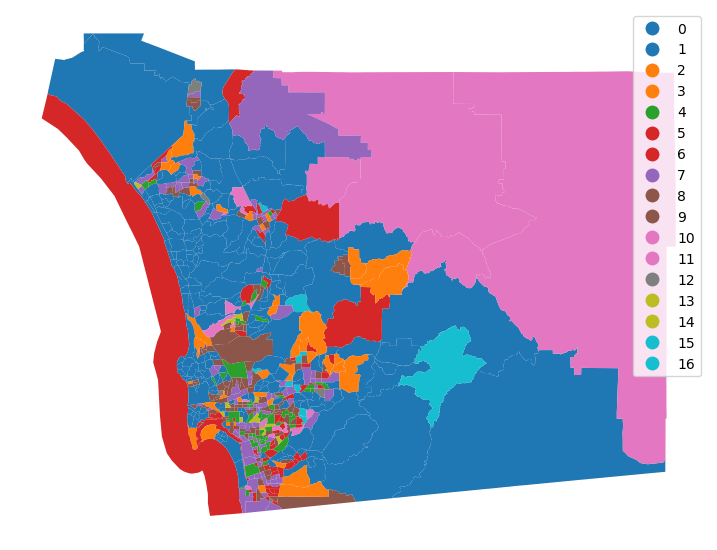

In [46]:
# Setup figure and ax
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot unique values choropleth
# including a legend and with no boundary lines
db.plot(
    column="antclust",
    categorical=True,
    legend=True,
    linewidth=0,
    ax=ax,
)
# Remove axis
ax.set_axis_off()
# Display the map
plt.show()

# Metrics

**Geographical coherence**

In [43]:
results = []
for cluster_type in ("k5cls", "ward5", "ward5wq", "ward5wknn","antclust"):
    # compute the region polygons using a dissolve
    regions = db[[cluster_type, "geometry"]].dissolve(by=cluster_type)
    # compute the actual isoperimetric quotient for these regions
    ipqs = (
        regions.area * 4 * numpy.pi / (regions.boundary.length ** 2)
    )
    # cast to a dataframe
    result = ipqs.to_frame(cluster_type)
    results.append(result)
# stack the series together along columns
pandas.concat(results, axis=1)

,k5cls,ward5,ward5wq,ward5wknn,antclust
0,0.019571,0.018571,0.074571,0.139216,0.023222
1,0.054901,0.149260,0.129419,0.245486,0.038694
2,0.034567,0.046086,0.542491,0.050342,0.039422
3,0.048698,0.064358,0.281874,0.542491,0.047791
4,0.027704,0.027323,0.112495,0.123690,0.017142
5,NaN,NaN,NaN,NaN,0.029473
6,NaN,NaN,NaN,NaN,0.057538
7,NaN,NaN,NaN,NaN,0.017292
8,NaN,NaN,NaN,NaN,0.018268
9,NaN,NaN,NaN,NaN,0.015854


**Feature coherence**

In [44]:
ch_scores = []
for cluster_type in ("k5cls", "ward5", "ward5wq", "ward5wknn","antclust"):
    # compute the CH score
    ch_score = metrics.calinski_harabasz_score(
        # using scaled variables
        robust_scale(db[cluster_variables]),
        # using these labels
        db[cluster_type],
    )
    # and append the cluster type with the CH score
    ch_scores.append((cluster_type, ch_score))

# re-arrange the scores into a dataframe for display
pandas.DataFrame(
    ch_scores, columns=["cluster type", "CH score"]
).set_index("cluster type")

,CH score
cluster type,
k5cls,106.907609
ward5,98.529245
ward5wq,62.518714
ward5wknn,54.378576
antclust,19.338995


In [48]:
siluette_scores = []
for cluster_type in ("k5cls", "ward5", "ward5wq", "ward5wknn","antclust"):
    # compute the CH score
    siluette = metrics.silhouette_score(
        # using scaled variables
        robust_scale(db[cluster_variables]),
        # using these labels
        db[cluster_type],
    )
    # and append the cluster type with the CH score
    siluette_scores.append((cluster_type, siluette))

# re-arrange the scores into a dataframe for display
pandas.DataFrame(
    siluette_scores, columns=["cluster type", "Silhouette score"]
).set_index("cluster type")

,Silhouette score
cluster type,
k5cls,0.185683
ward5,0.162304
ward5wq,0.061462
ward5wknn,0.049983
antclust,-0.167726


**Solution similarity**

In [49]:
ami_scores = []
# for each cluster solution
for i_cluster_type in ("k5cls", "ward5", "ward5wq", "ward5wknn","antclust"):
    # for every other clustering
    for j_cluster_type in ("k5cls", "ward5", "ward5wq", "ward5wknn","antclust"):
        # compute the adjusted mutual info between the two
        ami_score = metrics.adjusted_rand_score(
            db[i_cluster_type], db[j_cluster_type]
        )
        # and save the pair of cluster types with the score
        ami_scores.append((i_cluster_type, j_cluster_type, ami_score))
# arrange the results into a dataframe
results = pandas.DataFrame(
    ami_scores, columns=["source", "target", "similarity"]
)
# and spread the dataframe out into a square
results.pivot(index="source",columns= "target", values="similarity")

target,antclust,k5cls,ward5,ward5wknn,ward5wq
source,,,,,
antclust,1.000000,0.197746,0.113075,0.041860,0.040474
k5cls,0.197746,1.000000,0.466614,0.239897,0.256580
ward5,0.113075,0.466614,1.000000,0.268306,0.247367
ward5wknn,0.041860,0.239897,0.268306,1.000000,0.654506
ward5wq,0.040474,0.256580,0.247367,0.654506,1.000000
